# COVID19 evolution analysis

#### data loading

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.expanduser(os.path.join('~','Documents', 'projects', 'coronavirus')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src import tools
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from src.data_downloader import DATA_REPOS, download_from_repo

### update data from repos

In [2]:
dest=os.path.expanduser(os.path.join('~','Documents', 'projects', 'coronavirus', 'data'))

In [70]:
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['deaths'], dest=dest)
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['confirmed'], dest=dest)
download_from_repo(DATA_REPOS['world']['url'], filename=DATA_REPOS['world']['streams']['recovered'], dest=dest)
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['andamento-nazionale'], dest=dest)
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['regioni'], dest=dest)
download_from_repo(DATA_REPOS['italy']['url'], filename=DATA_REPOS['italy']['streams']['province'], dest=dest)

last commit  2020-03-24 18:24:50
last commit  2020-03-24 18:24:50
last commit  2020-03-24 18:24:50
last commit  2020-03-24 18:34:11
last commit  2020-03-24 18:34:11
last commit  2020-03-24 18:34:11


### load data

In [71]:
df_naz = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
reg = pd.read_csv('../data/dpc-covid19-ita-regioni.csv')
prov = pd.read_csv('../data/dpc-covid19-ita-province.csv').drop('stato',1)
df_naz.index = pd.to_datetime(df_naz.index)
reg['data'] = pd.to_datetime(reg['data'])
prov['data'] = pd.to_datetime(prov['data'])
df_world_confirmed = pd.read_csv('../data/time_series_19-covid-Confirmed.csv')
df_world_deaths = pd.read_csv('../data/time_series_19-covid-Deaths.csv')
df_world_recovered = pd.read_csv('../data/time_series_19-covid-Recovered.csv')
populations = pd.read_csv('../data/API_SP.POP.TOTL_DS2_en_csv_v2.csv', skiprows=4, engine='python').set_index('Country Name')['2018']
df_world_confirmed['pop'] = df_world_confirmed['Country/Region'].map(populations)
df_world_deaths['pop'] = df_world_deaths['Country/Region'].map(populations)
df_world_recovered['pop'] = df_world_recovered['Country/Region'].map(populations)
df_naz = tools.add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
for item in regions.groups:
    df_reg[item] = tools.add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)
provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,tools.add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)

In [72]:
date_cols = [item for item in df_world_confirmed.columns if '/20' in item]

In [73]:
df_world_confirmed.pivot_table(index='Country/Region', values=date_cols).T.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
3/5/20,1.0,0.0,12.0,1.0,0.0,0.0,1.0,1.0,6.111111,41.0,...,0.0,1.0,29.0,16.571429,0.0,0.0,0.0,16.0,0.0,0.0
3/6/20,1.0,0.0,17.0,1.0,0.0,0.0,2.0,1.0,6.666667,55.0,...,0.0,1.0,29.0,23.428571,0.0,0.0,0.0,16.0,0.0,0.0
3/7/20,1.0,0.0,17.0,1.0,0.0,0.0,8.0,1.0,7.000000,79.0,...,0.0,1.0,45.0,29.571429,0.0,0.0,0.0,18.0,0.0,0.0
3/8/20,4.0,0.0,19.0,1.0,0.0,0.0,12.0,1.0,8.444444,104.0,...,0.0,1.0,45.0,39.142857,0.0,0.0,0.0,30.0,0.0,0.0
3/9/20,4.0,2.0,20.0,1.0,0.0,0.0,12.0,1.0,10.111111,131.0,...,0.0,1.0,45.0,46.000000,0.0,0.0,0.0,30.0,0.0,0.0


## Italy

### diffusion heatmap for provinces

In [74]:
col = 'totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov[df_prov.index==df_prov.index.max()].index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

In [75]:
col = '%delta_totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov.index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

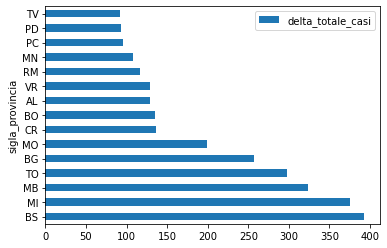

In [76]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', 'delta_totale_casi']].sort_values(by='delta_totale_casi', ascending=False)[:15].set_index('sigla_provincia').plot(kind='barh')

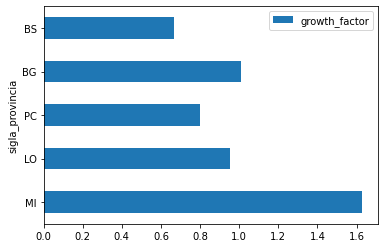

In [77]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', 'growth_factor']].set_index('sigla_provincia').loc[['MI','LO','PC','BG','BS']].plot(kind='barh')

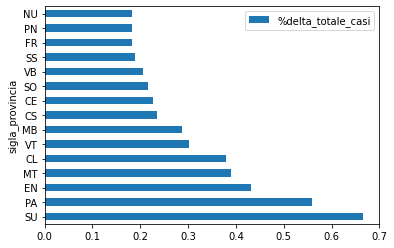

In [78]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', '%delta_totale_casi']].sort_values(by='%delta_totale_casi', ascending=False)[:15].set_index('sigla_provincia').plot(kind='barh')

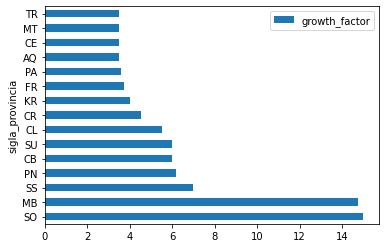

In [79]:
df_prov[df_prov.index==df_prov.index.max()][['sigla_provincia', 'growth_factor']].sort_values(by='growth_factor', ascending=False)[:15].set_index('sigla_provincia').plot(kind='barh')

In [80]:
df_prov

,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,delta_totale_casi,%delta_totale_casi,growth_factor
data,,,,,,,,,,,
02/24/2020,19,Sicilia,84,Agrigento,AG,37.309711,13.584575,0,0.0,0.000000,0.000000
02/25/2020,19,Sicilia,84,Agrigento,AG,37.309711,13.584575,0,0.0,0.000000,0.000000
02/26/2020,19,Sicilia,84,Agrigento,AG,37.309711,13.584575,0,0.0,0.000000,0.000000
02/27/2020,19,Sicilia,84,Agrigento,AG,37.309711,13.584575,0,0.0,0.000000,0.000000
02/28/2020,19,Sicilia,84,Agrigento,AG,37.309711,13.584575,0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
03/20/2020,18,Calabria,102,Vibo Valentia,VV,38.676241,16.101574,8,0.0,0.000000,0.000000
03/21/2020,18,Calabria,102,Vibo Valentia,VV,38.676241,16.101574,11,3.0,0.375000,0.000000
03/22/2020,18,Calabria,102,Vibo Valentia,VV,38.676241,16.101574,14,3.0,0.272727,1.000000


### National evolution

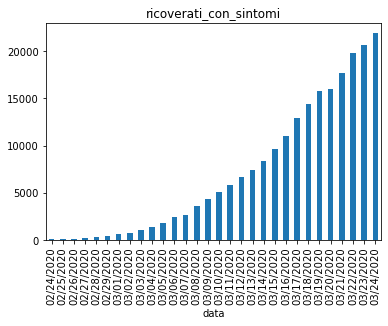

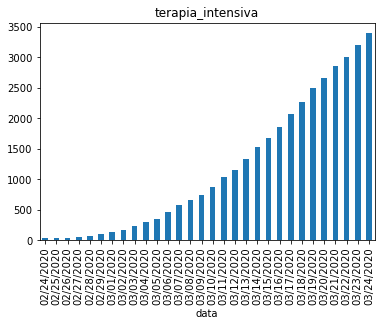

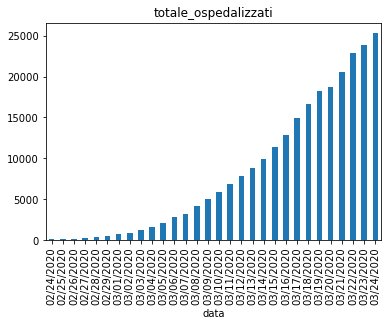

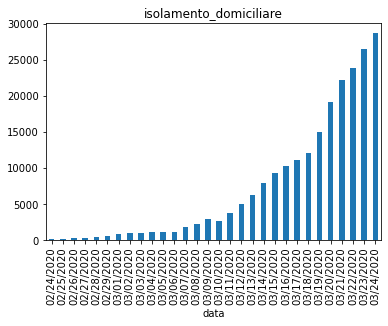

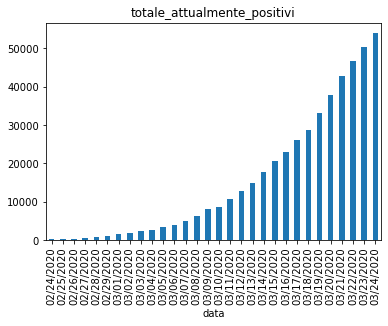

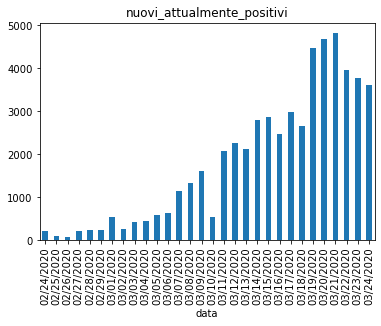

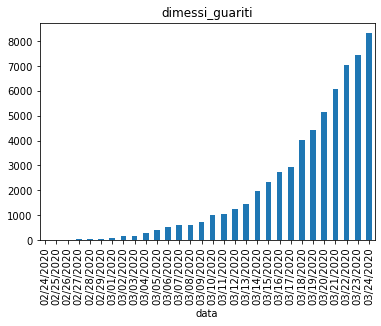

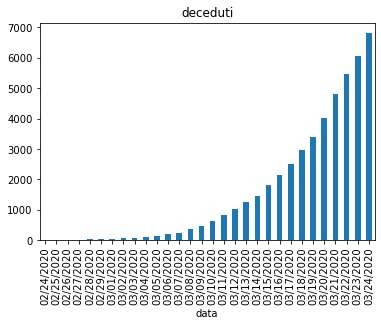

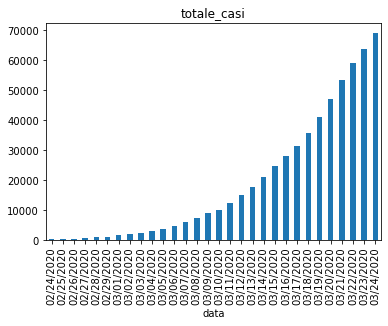

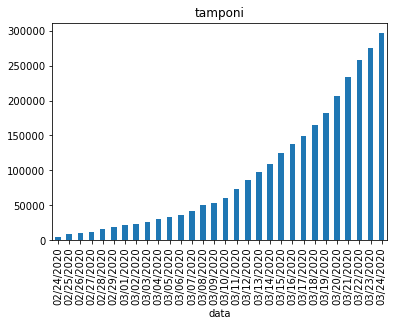

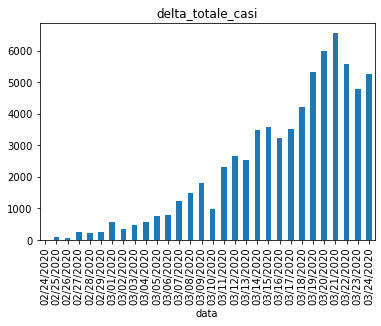

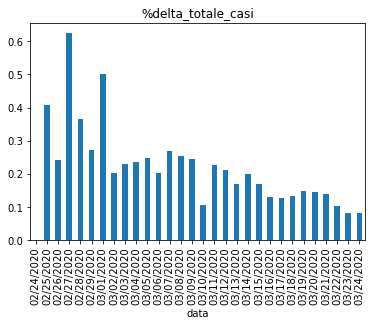

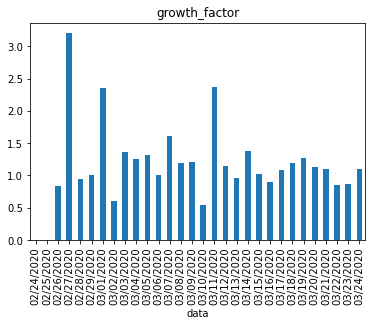

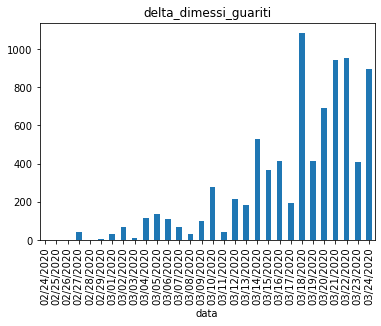

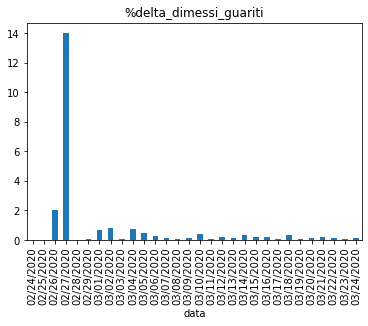

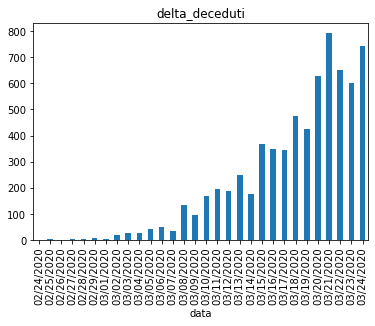

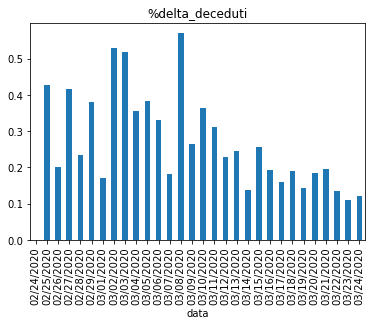

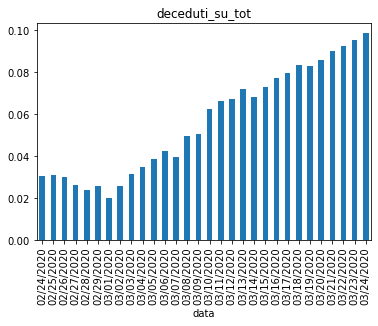

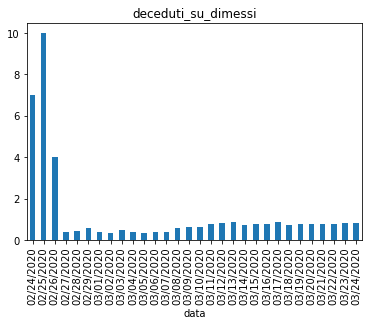

In [81]:
for col in df_naz.columns:
    plt.figure()
    df_naz[col].plot(kind='bar', title=col)    

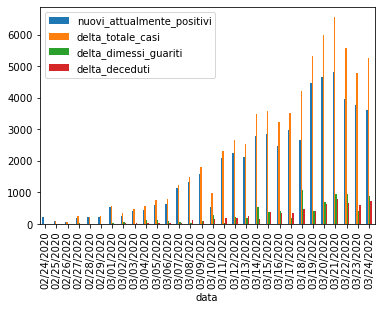

In [82]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].plot(kind='bar')

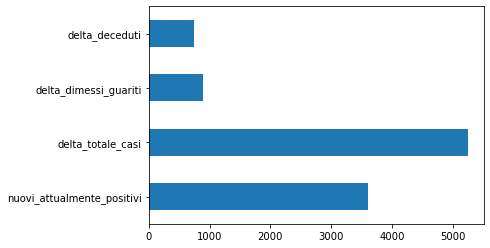

In [83]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].iloc[-1].plot(kind='barh')

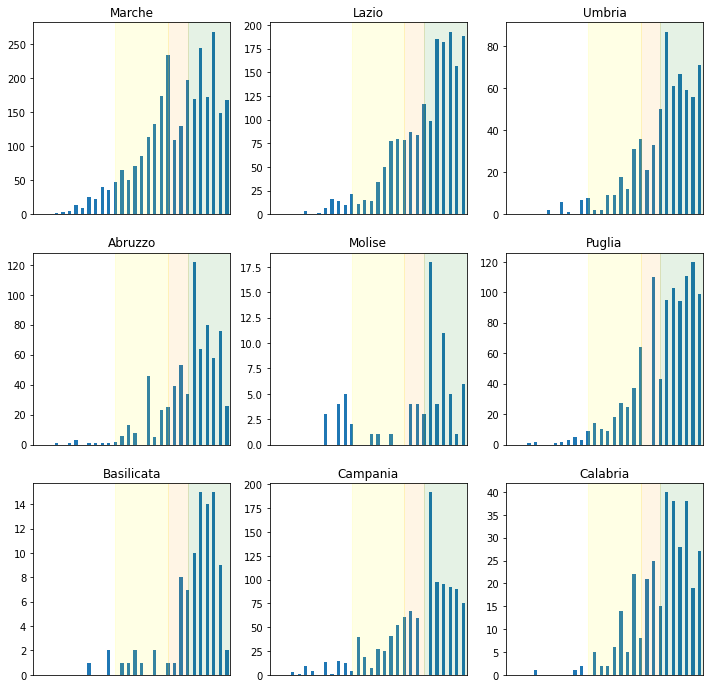

In [84]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))#, sharex=True, sharey=True)
for x, (ax, reg) in enumerate(zip(axes.flatten(),['Marche','Lazio','Umbria',
        'Abruzzo','Molise','Puglia','Basilicata', 'Campania','Calabria'])):
    
    df_reg[reg]['delta_totale_casi'].plot(kind='bar', ax=ax)
    ax.axvspan(12, 20, alpha=0.1, color='yellow')
    ax.axvspan(20, 23, alpha=0.1, color='orange')
    ax.axvspan(23, 30, alpha=0.1, color='green')
    ax.get_xaxis().set_visible(False)
    ax.set_title(reg)

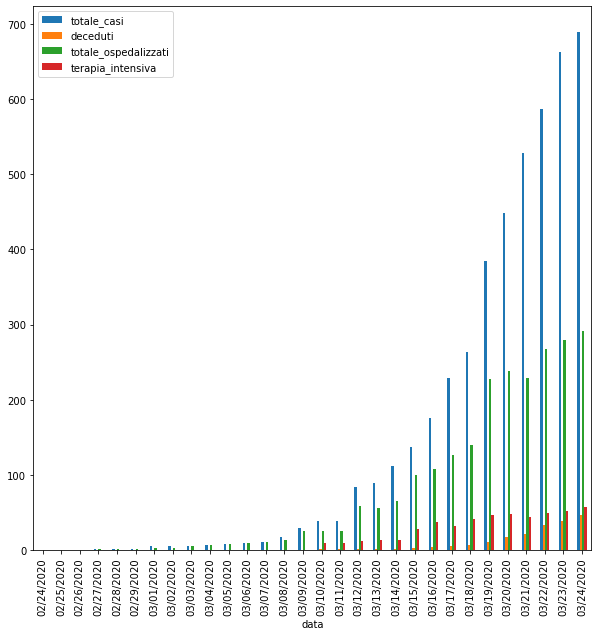

In [85]:
df_reg['Abruzzo'][['totale_casi', 'deceduti', 'totale_ospedalizzati', 'terapia_intensiva']].plot(kind='bar', figsize=(10,10))

### Logistic model evolution

### National Analysis

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



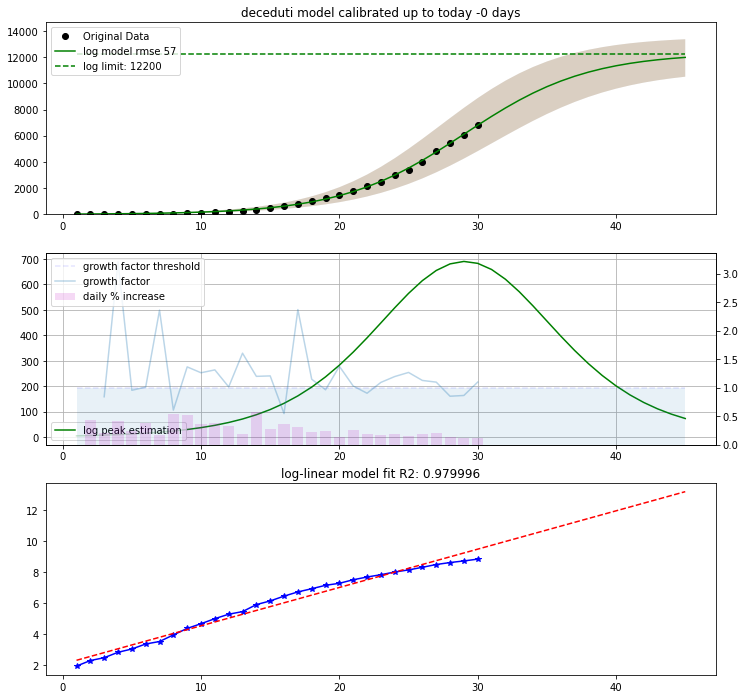

next day prediction for log model:  7473
data
03/20/2020    4032
03/21/2020    4825
03/22/2020    5476
03/23/2020    6077
03/24/2020    6820
Name: deceduti, dtype: int64


In [86]:
tools.plot_model(df_naz, 'deceduti', backward_fit=0, stdev=2, forward_look=15, plotdifferential=True, plotlimit=True, show_pol=False, show_exp=False)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



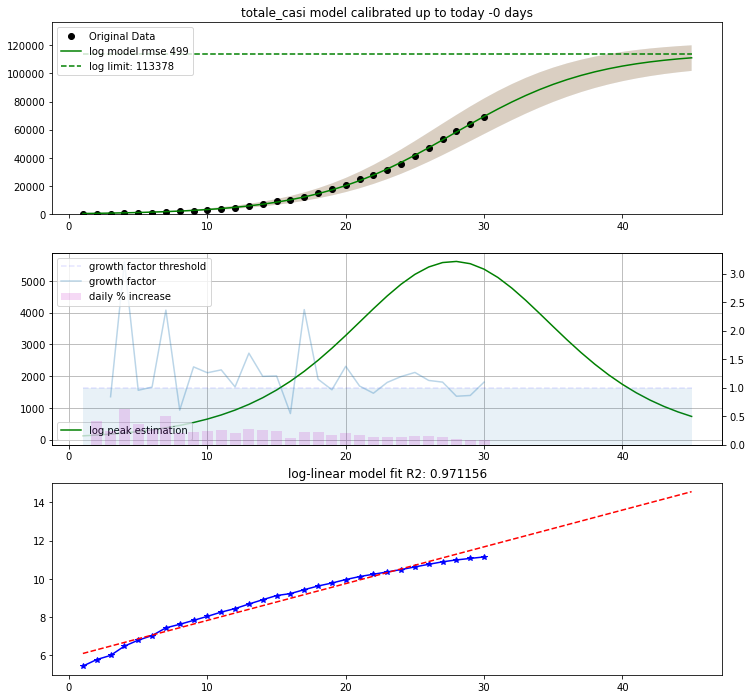

next day prediction for log model:  74698
data
03/20/2020    47021
03/21/2020    53578
03/22/2020    59138
03/23/2020    63927
03/24/2020    69176
Name: totale_casi, dtype: int64


In [87]:
tools.plot_model(df_naz, 'totale_casi', backward_fit=0, stdev=2, forward_look=15, plotdifferential=True, plotlimit=True, show_pol=False, show_exp=False)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



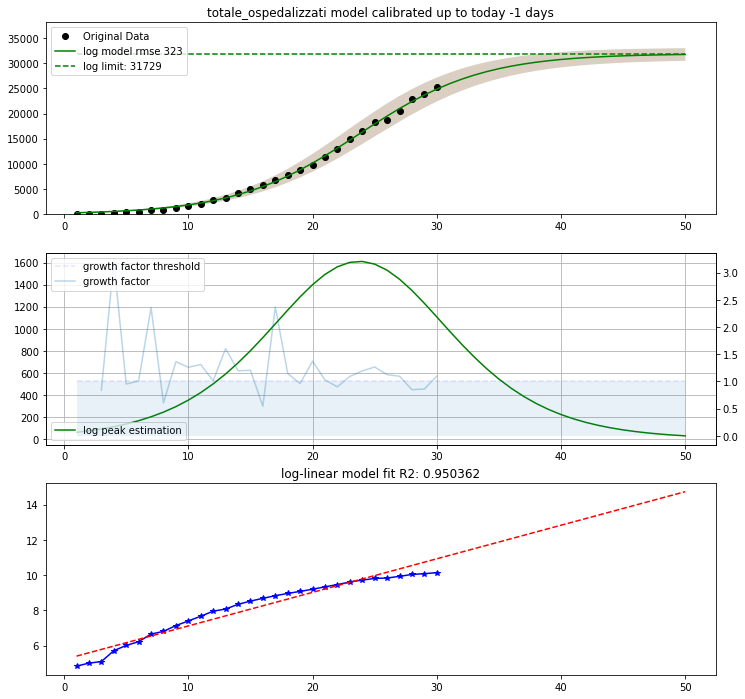

next day prediction for log model:  25898
data
03/20/2020    18675
03/21/2020    20565
03/22/2020    22855
03/23/2020    23896
03/24/2020    25333
Name: totale_ospedalizzati, dtype: int64


In [88]:
tools.plot_model(df_naz, 'totale_ospedalizzati', backward_fit=1, forward_look=20, plotlimit=True, show_pol=False, show_exp=False)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



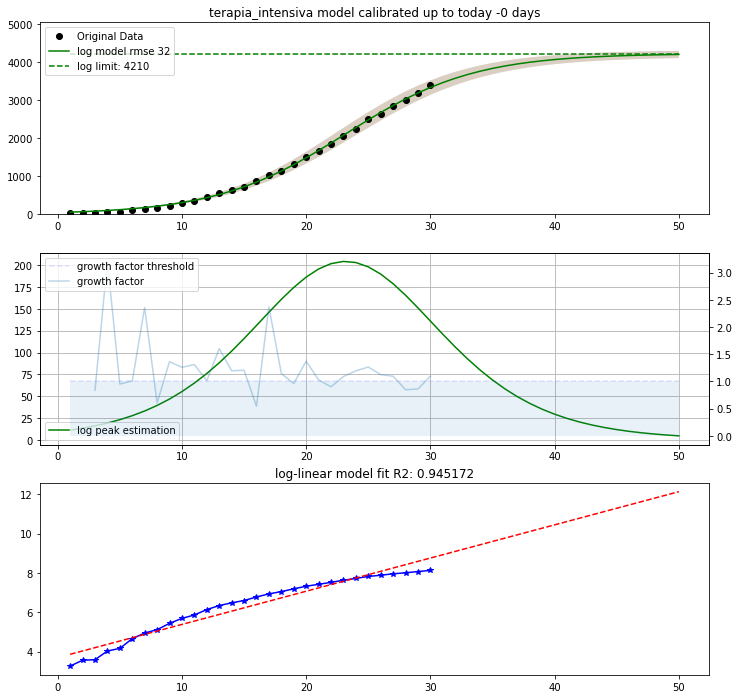

next day prediction for log model:  3469
data
03/20/2020    2655
03/21/2020    2857
03/22/2020    3009
03/23/2020    3204
03/24/2020    3396
Name: terapia_intensiva, dtype: int64


In [94]:
tools.plot_model(df_naz, 'terapia_intensiva', backward_fit=0, forward_look=20, plotlimit=True, show_pol=False, show_exp=False)

### Regional Analysis

In [106]:
region='Lombardia'

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



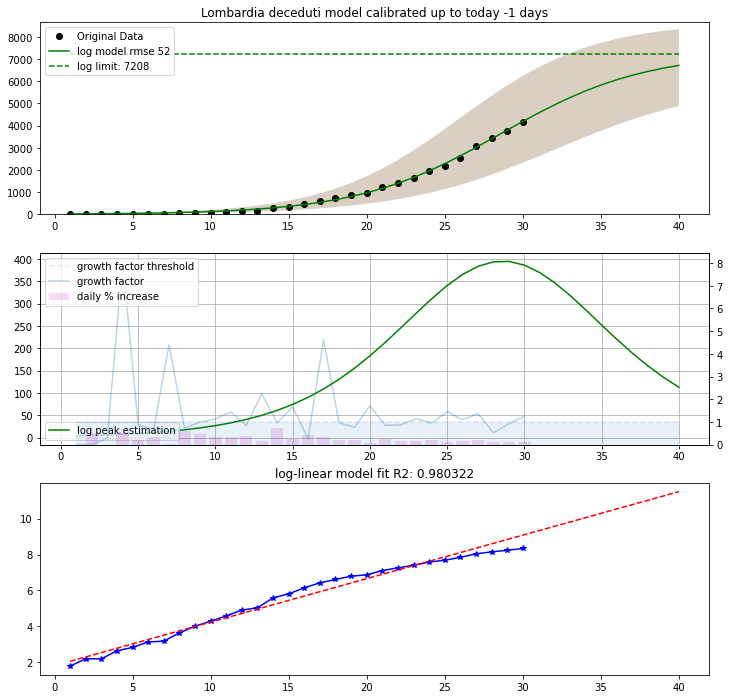

next day prediction for log model:  4567
data
03/20/2020    2549
03/21/2020    3095
03/22/2020    3456
03/23/2020    3776
03/24/2020    4178
Name: deceduti, dtype: int64


In [107]:
tools.plot_model(df_reg[region], 'deceduti', backward_fit=1, stdev=2, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label=region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



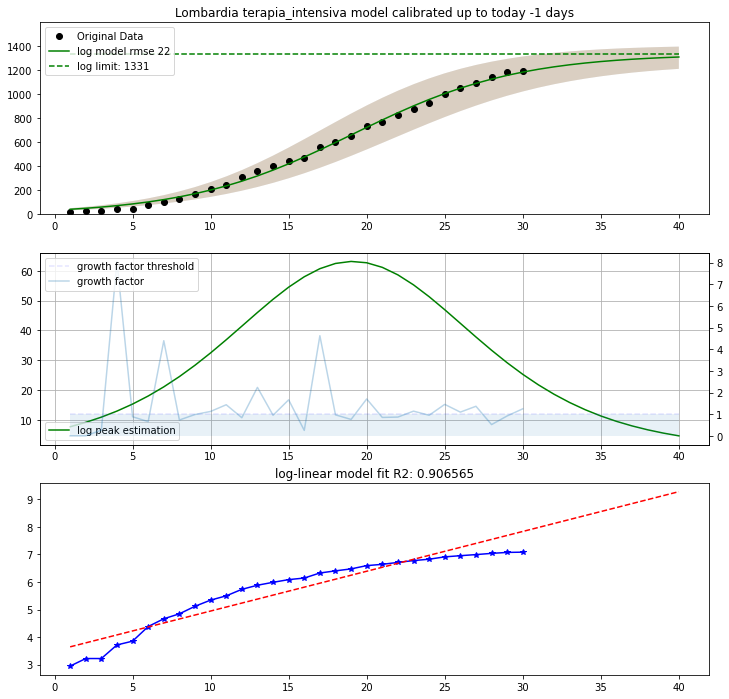

next day prediction for log model:  1207
data
03/20/2020    1050
03/21/2020    1093
03/22/2020    1142
03/23/2020    1183
03/24/2020    1194
Name: terapia_intensiva, dtype: int64


In [108]:
tools.plot_model(df_reg[region], 'terapia_intensiva', backward_fit=1, stdev=2, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label = region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



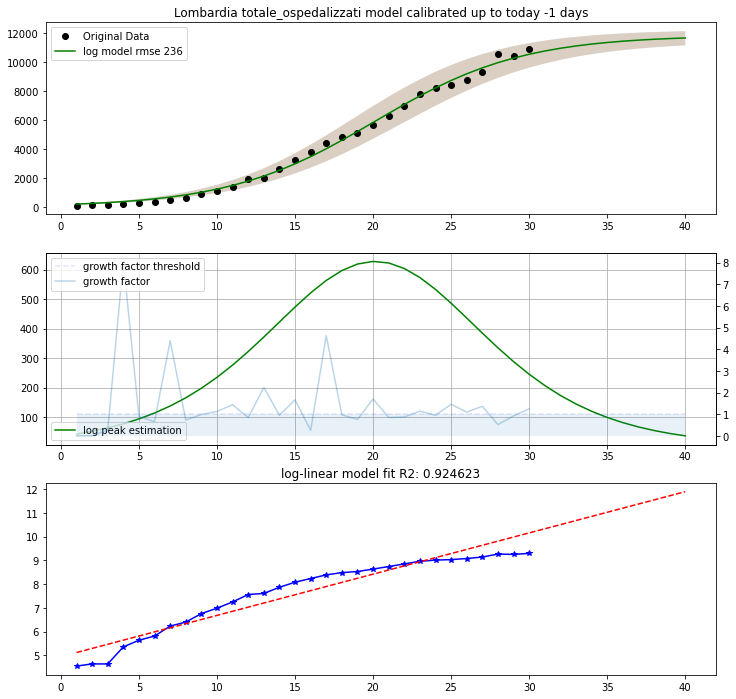

next day prediction for log model:  10765
data
03/20/2020     8785
03/21/2020     9351
03/22/2020    10581
03/23/2020    10449
03/24/2020    10905
Name: totale_ospedalizzati, dtype: int64


In [109]:
tools.plot_model(df_reg[region], 'totale_ospedalizzati', backward_fit=1, forward_look=10, plotlimit=False, 
                 show_pol=False, show_exp=False, label=region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



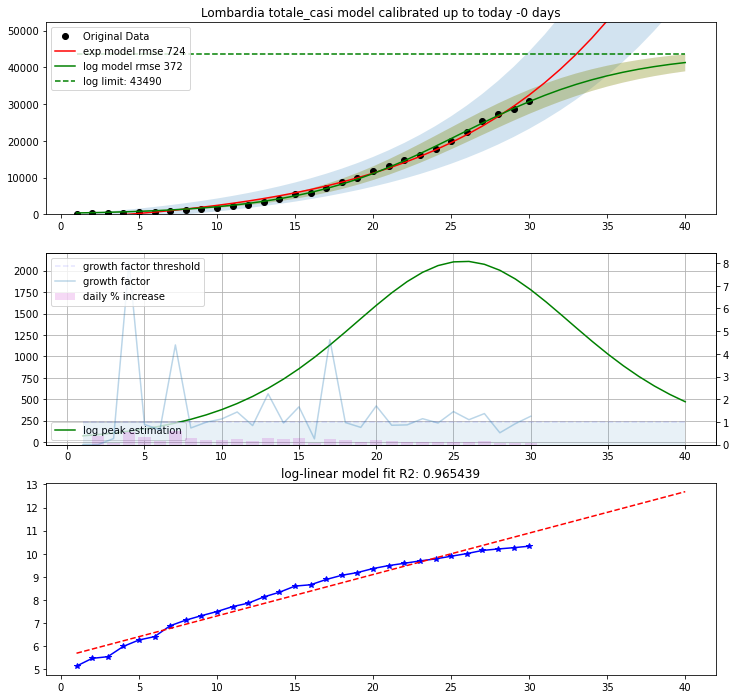

next day prediction for log model:  32370
next day prediction for exp model:  35814
data
03/20/2020    22264
03/21/2020    25515
03/22/2020    27206
03/23/2020    28761
03/24/2020    30703
Name: totale_casi, dtype: int64


In [110]:
tools.plot_model(df_reg[region], 'totale_casi', backward_fit=0, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=True, label=region)

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



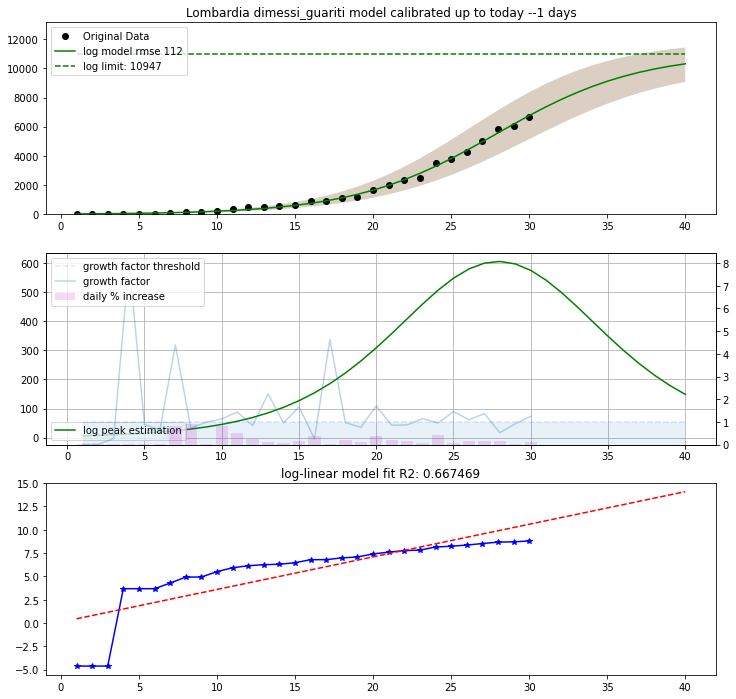

next day prediction for log model:  7318
data
03/20/2020    4295.0
03/21/2020    5050.0
03/22/2020    5865.0
03/23/2020    6075.0
03/24/2020    6657.0
Name: dimessi_guariti, dtype: float64


In [111]:
tools.plot_model(df_reg[region].replace(0,0.01), 'dimessi_guariti', backward_fit=-1, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=False, label=region)

### Lombardy evolution for provinces

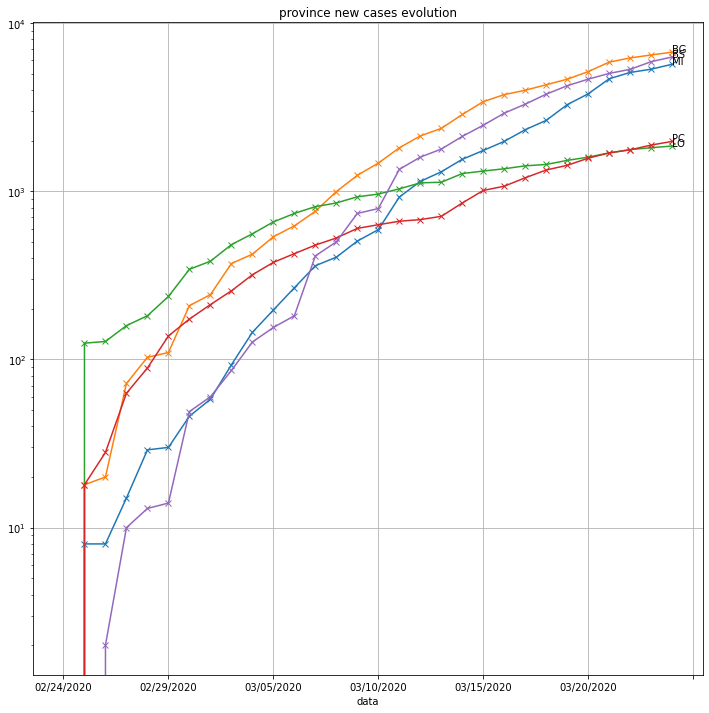

In [112]:
prov_analysis = df_prov.reset_index().pivot_table(index='data', columns='sigla_provincia', 
            values='totale_casi')[['MI', 'BG', 'LO', 'PC', 'BS']]
prov_analysis.plot(kind='line', style='x-', figsize=(12,12), legend=False)
for label in ['MI', 'BG', 'LO', 'PC', 'BS']:
    plt.annotate(label, xy=(len(prov_analysis)-1, prov_analysis[label].iloc[-1]),textcoords='data')
plt.title('province new cases evolution')
plt.grid()
plt.yscale('log')

### china comparison

C:\Users\Maurizio Spadaccino\Documents\projects\coronavirus\src\tools.py:112: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



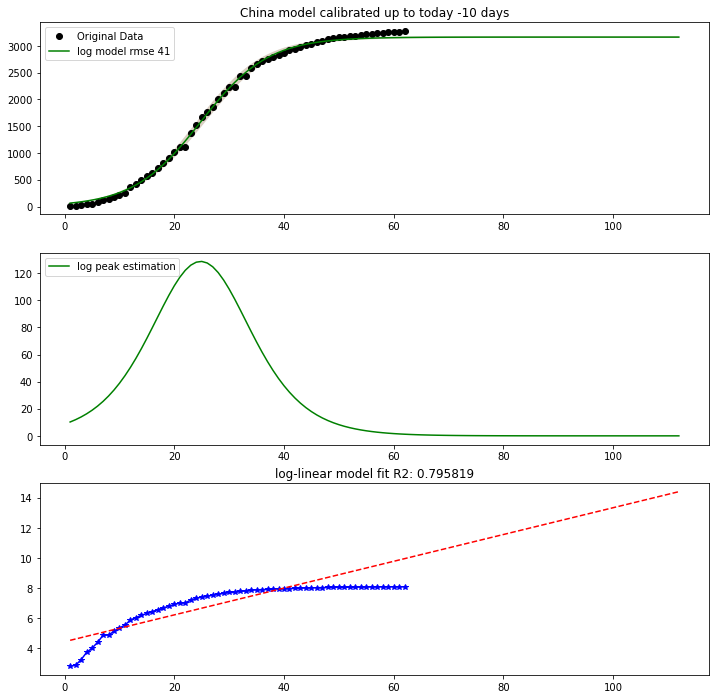

next day prediction for log model:  3157
2020-03-19    3249.0
2020-03-20    3253.0
2020-03-21    3259.0
2020-03-22    3265.0
2020-03-23    3274.0
Name: China, dtype: float64


In [23]:
china_deaths = df_world_deaths[df_world_deaths['Country/Region']=='China'].groupby('Country/Region').sum().drop('Lat',1).drop('Long',1).T.iloc[:-1]
china_deaths.index = pd.to_datetime(china_deaths.index)
tools.plot_model(china_deaths, 'China', backward_fit=10, forward_look=50, plotdifferential=True, plotlimit=False, show_pol=False, show_exp=False)

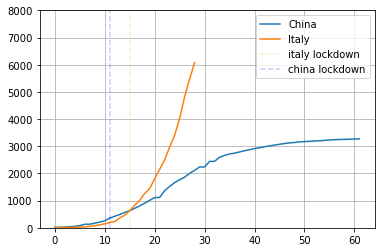

In [24]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), df_naz['deceduti'].reset_index(drop=True)], 
                            axis=1))
df_compare.columns = ['China','Italy']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=15, label='italy lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

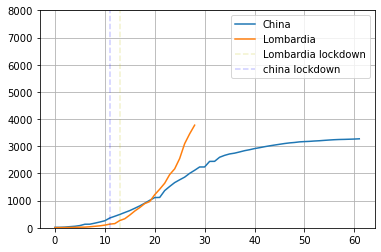

In [25]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), 
                    df_reg['Lombardia']['deceduti'].reset_index(drop=True)], axis=1))
df_compare.columns = ['China','Lombardia']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=13, label='Lombardia lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

## World comparisons

In [27]:
df_world_deaths['Country/Region'].unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'San Marino', 'Belarus', 'Iceland', 'Lithuania',
       'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile',
       'Jordan', 'Ukraine', 'Hungary', 'Liechtenstein', 'Poland',
       'Tunisia', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa',
       'Bhutan', 'Cameroon', 'Colombia', 'Costa R

In [113]:
countries = ['Spain', 'Italy', 'Germany', 'France', 'United Kingdom', 'US', 'Japan', 'Korea, South']
df_countries = pd.DataFrame()
df_countries_stripped = pd.DataFrame()
for country in countries:
    print(country)
    df_countries = pd.concat((df_countries, df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0)), 1)
    temp = df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0).reset_index(drop=True)    
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    df_countries_stripped= pd.concat((df_countries_stripped,  temp), 1)
df_countries.columns = countries
#df_countries_stripped = pd.concat((pd.DataFrame(np.zeros((1,len(countries))), columns=countries), df_countries_stripped),0).reset_index(drop=True)

Spain
Italy
Germany
France
United Kingdom
US
Japan
Korea, South


In [114]:
start_dates = {}
start_dates['Spain'] = '3/3/20'
start_dates['Italy'] = '2/21/20'
start_dates['Germany'] = '3/9/20'
start_dates['France'] = '2/25/20'
start_dates['United Kingdom'] = '3/5/20'
start_dates['US'] = '3/1/20'

country_offsets = {key:0 for key in countries}
#country_offsets['Spain'] = 0
#country_offsets['Italy'] = 0
#country_offsets['Germany'] = 0
country_offsets['France'] = -10
#country_offsets['United Kingdom'] = 0
country_offsets['US'] = -2
country_offsets['Japan'] = -13

populations.loc['US'] = populations.loc['United States']
populations.loc['Korea, South'] = populations.loc['Korea, Rep.']

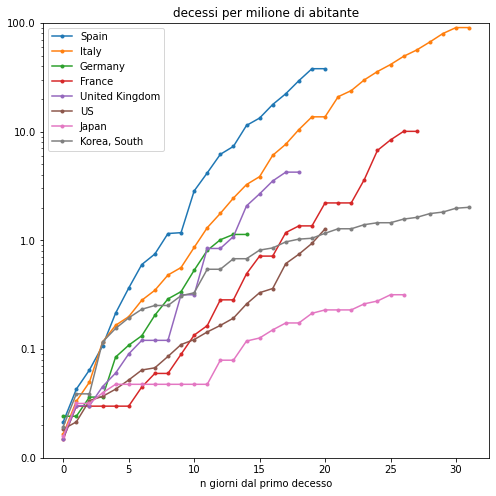

In [115]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    plt.plot(df_countries_stripped[country].shift(country_offsets[country]) / populations.loc[country] *1e6, '.-', label=country, )
plt.title('decessi per milione di abitante')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0.01, top=100)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

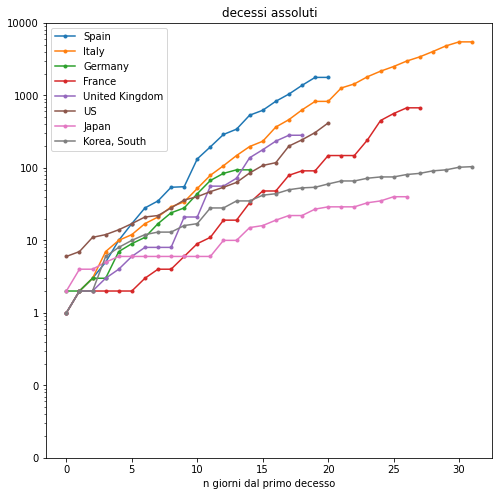

In [116]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    plt.plot(df_countries_stripped[country].shift(country_offsets[country]), '.-', label=country)
plt.title('decessi assoluti')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0.01, top=10000)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

In [117]:
df_world_deaths

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,pop
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1.0,69428524.0
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,22,27,29,29,29,33,35,40,40.0,126529100.0
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2.0,5638676.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,28087871.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,2,2,2,3,4,10,10.0,31528585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,NaN,Jersey,49.1900,-2.1100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
497,NaN,Puerto Rico,18.2000,-66.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,3195153.0
498,NaN,Republic of the Congo,-1.4400,15.5560,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
499,NaN,The Bahamas,24.2500,-76.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN


In [64]:
df_world_deaths['Province/State'].unique()

array([nan, 'British Columbia', 'New South Wales', 'Victoria',
       'Queensland', 'South Australia', 'From Diamond Princess',
       'Western Australia', 'Tasmania', 'Northern Territory', 'Ontario',
       'Alberta', 'Quebec', 'Washington', 'New York', 'California',
       'Massachusetts', 'Diamond Princess', 'Grand Princess', 'Georgia',
       'Colorado', 'Florida', 'New Jersey', 'Oregon', 'Texas', 'Illinois',
       'Pennsylvania', 'Iowa', 'Maryland', 'North Carolina',
       'South Carolina', 'Tennessee', 'Virginia', 'Arizona', 'Indiana',
       'Kentucky', 'District of Columbia', 'Nevada', 'New Hampshire',
       'Minnesota', 'Nebraska', 'Ohio', 'Rhode Island', 'Wisconsin',
       'Connecticut', 'Hawaii', 'Oklahoma', 'Utah', 'Kansas', 'Louisiana',
       'Missouri', 'Vermont', 'Alaska', 'Arkansas', 'Delaware', 'Idaho',
       'Maine', 'Michigan', 'Mississippi', 'Montana', 'New Mexico',
       'North Dakota', 'South Dakota', 'West Virginia', 'Wyoming',
       'Hubei', 'France', 'G

California
Texas
New Jersey
New York


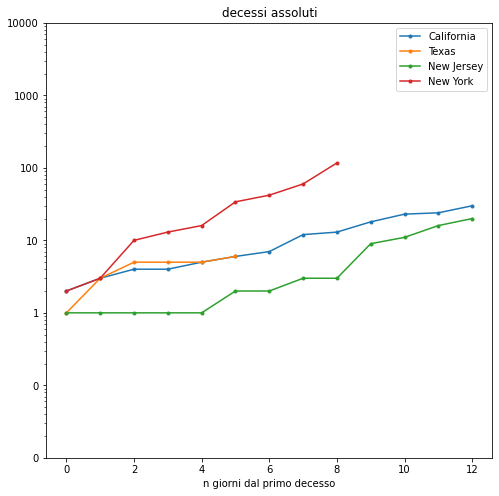

In [119]:
regions = ['California', 'Texas', 'New Jersey', 'New York']
region_offsets = {key:0 for key in regions}
#country_offsets['Spain'] = 0
#country_offsets['Italy'] = 0
#country_offsets['Germany'] = 0
#region_offsets['France'] = -10
#country_offsets['United Kingdom'] = 0
#region_offsets['US'] = -2
#region_offsets['Japan'] = -13
df_us_regions = pd.DataFrame()
df_us_regions_stripped = pd.DataFrame()
for region in regions:
    print(region)
    df_us_regions = pd.concat((df_us_regions, df_world_deaths.groupby('Province/State').sum().loc[region].drop(['Lat','Long'],0)), 1)
    temp = df_world_deaths.groupby('Province/State').sum().loc[region].drop(['Lat','Long'],0).reset_index(drop=True)    
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    df_us_regions_stripped= pd.concat((df_us_regions_stripped,  temp), 1)
df_us_regions.columns = regions

fig, ax = plt.subplots(figsize=(8,8))
for region in regions:
    plt.plot(df_us_regions_stripped[region].shift(region_offsets[region]), '.-', label=region)
plt.title('decessi assoluti')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0.01, top=10000)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

## The SIR epidemic model

(see https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/ and 
https://www.r-bloggers.com/epidemiology-how-contagious-is-novel-coronavirus-2019-ncov/)

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:

S(t) are those susceptible but not yet infected with the disease;
I(t) is the number of infectious individuals;
R(t) are those individuals who have recovered from the disease and now have immunity to it.
The SIR model describes the change in the population of each of these compartments in terms of two parameters, β and γ. β describes the effective contact rate of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N). γ is the mean recovery rate: that is, 1/γ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:

$dSdt=−βSI/N$ <br>
$dIdt=β(SI)/N−γI$ <br>
$dRdt=γI$ <br>

The following Python code integrates these equations for a disease characterised by parameters β=0.2, 1/γ=10days in a population of N=1000 (perhaps 'flu in a school). The model is started with a single infected individual on day 0: I(0)=1. The plotted curves of S(t), I(t) and R(t) are styled to look a bit nicer than Matplotlib's defaults.

In [113]:
# SIR model differential equations
def deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def SIRModel_diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


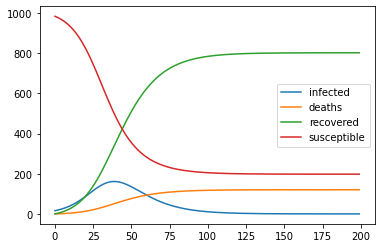

In [114]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  4.133901438652102
gamma:  3.916273001347615
theta:  0.007456309076935952
r0:  1.0555702927833683
mean period of time of infection:  0.25534481371852613
max number of infections  85796.62521623963
max number of deaths  11918.933828348876
mae  41.91589386478325


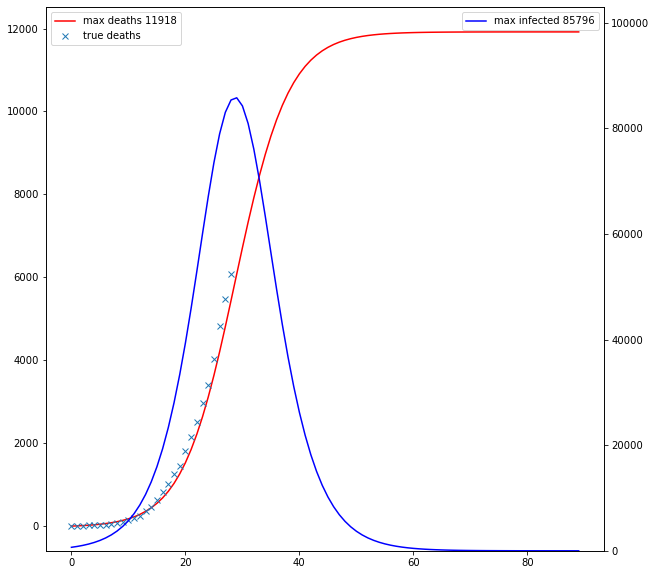

In [115]:
use_differential_evolution = True
cases_multiplier = 3
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(0,5), (0, 5), (0, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(SIRModel_diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(D,'r', label='max deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='max infected '+str(int(np.max(I))))
#ax2.plot(R,'g', label='recovered')
#ax2.plot(S,'y', label='susceptible')

ax2.legend()

calibrating with genetic algorithm...
beta:  2.670559130855131
gamma:  2.4148545646111543
theta:  0.0014141426556641935
r0:  1.1058881847342847
mean period of time of infection:  0.41410361296893355
max number of infections  287418.23357014806
max number of deaths  6564.007105420608
mae  20.015289666188046

In [28]:
df_china = pd.DataFrame()
df_china['deaths'] = df_world_deaths.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)
df_china['recovered'] = df_world_recovered.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)
df_china['confirmed'] = df_world_confirmed.groupby('Country/Region').sum().loc['China'].drop(['Lat','Long'],0)

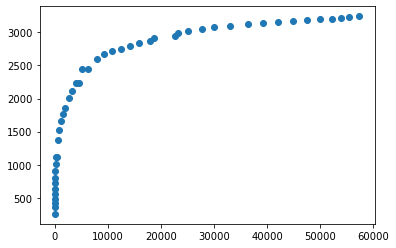

In [177]:
plt.scatter(df_china['recovered'].shift(10).drop(['pop']), df_china['deaths'].drop(['pop']))

In [173]:
pd.concat([df_china['recovered'].shift(10).drop(['pop']), df_china['recovered'].drop(['pop']), df_china['deaths'].drop(['pop'])], 1)

,recovered,recovered,deaths
1/22/20,NaN,28.0,17.0
1/23/20,NaN,30.0,18.0
1/24/20,NaN,36.0,26.0
1/25/20,NaN,39.0,42.0
1/26/20,NaN,49.0,56.0
1/27/20,NaN,58.0,82.0
1/28/20,NaN,101.0,131.0
1/29/20,NaN,120.0,133.0
1/30/20,NaN,135.0,171.0
1/31/20,NaN,214.0,213.0


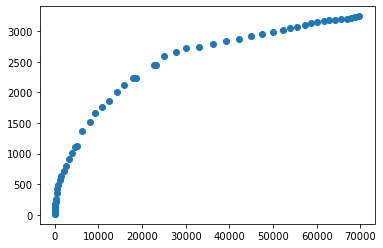

In [151]:
plt.scatter(df_china['recovered'].shift(0).drop(['pop']), df_china['deaths'].drop(['pop']))

In [127]:
import scipy.integrate as integrate
mortality_rate = 0.025
total_deaths =  integrate.quad(lambda x: SIRModel((x,), *optim_params)[1], 0, 100)[0]
print('total ', total_deaths)

total  221000.00000000006


## simulation using Facebook Phrophet Model

In [127]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\anaconda3\envs\coronavirus\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Traceback (most recent call last):
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\axis.py", line 1573, in convert_units
    ret = self.converter.convert(x, self.units, self)
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\category.py", line 61, in convert
    unit.update(values)
  File "c:\

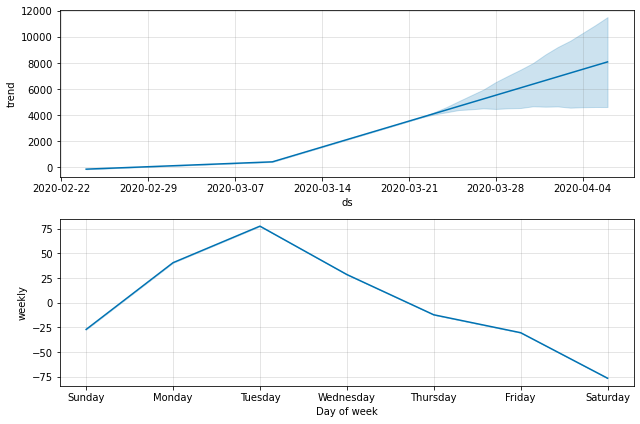

ValueError: view limit minimum -7.930656e+16 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

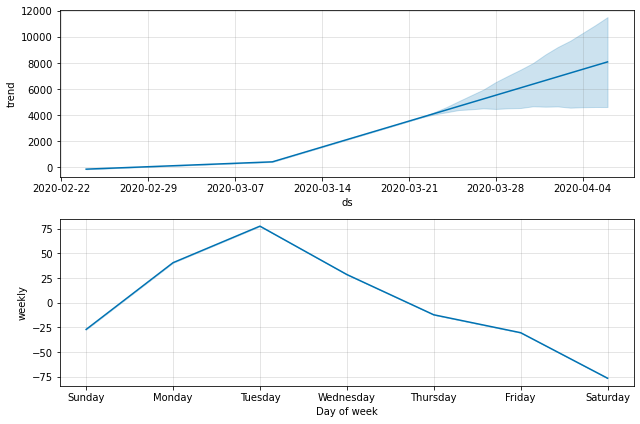

In [128]:

y = 'deceduti'
train_data = pd.DataFrame()
train_data['ds']=df_naz.index
train_data['y']=df_naz[y].reset_index(drop=True).values
growth = 'linear'
cap = 4000
floor = 0
if growth=='logistic':
    train_data['cap'] = cap
    train_data['floor'] = floor

m = Prophet(growth = growth, changepoints=['2020-03-10'], changepoint_prior_scale=0.75)
m.fit(train_data)
future = m.make_future_dataframe(periods=20)
if growth=='logistic':
    future['cap'] = cap
    future['floor'] = floor
forecast = m.predict(future)
fig = m.plot(forecast)

a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('prophet forecast for ' + y)
plt.plot(train_data.set_index('ds')['y'],'r*',label='actual data')
#plt.axvspan(whole_data.iloc[0]['ds'], train_data.iloc[-1]['ds'], alpha=0.15, color='red', label='train period')
#plt.axvspan(test_data.iloc[0]['ds'], test_data.iloc[-1]['ds'], alpha=0.15, color='green', label='test period')
plt.legend()
m.plot_components(forecast)
